In [1]:
# standard python imports
import sys
sys.path.append("/home/conradb/git/ifg-ssl")
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# pytorch + fastai imports
from fastai.vision.all import *
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms.functional as F
from torchvision.utils import make_grid

# local module imports
from dino.augment import ImageAugmentationDINO
from dino.loss import DINOLoss
import dino.utils as utils
import dino.vision_transformer as vit
from dino.vision_transformer import DINOHead

In [2]:
# augmentations
global_crops_scale = (0.4, 1.)
local_crops_scale = (0.05, 0.4)
local_crops_number = 8

# dataloader
batch_size = 128 #cpu
num_workers = 8
pin_memory = False #cpu

# model
model = 'vit_tiny' # embed_dim=192, depth=12, num_heads=3
out_dim = 16384 # complex and large datasets values like 65k work well
use_bn_head = False # use batch norm in head
norm_last_layer = True #  normalize the last layer of the DINO head, typically set this paramater to False with vit_small and True with vit_base

# dino specific
warmup_teacher_temp = 0.02 # Initial value for the teacher temperature, Try decreasing it if the training loss does not decrease
teacher_temp = 0.04
warmup_teacher_temp_epochs = 30 # 30 is default?

# compute
device ='cpu' # cpu or gpu

epochs = 100
# lr = 0.0005
lr = 5e-2
# min_lr = 1e-6
min_lr=5e-4
warmup_epochs = 10
weight_decay = 0.04
weight_decay_end = 0.4
# momentum_teacher = 0.996 # Base EMA parameter for teacher update. The value is increased to 1 during training with cosine schedule. We recommend setting a higher value with small batches: for example use 0.9995 with batch size of 256.""")
momentum_teacher = 0.99


In [3]:
path = untar_data(URLs.IMAGENETTE_160)

In [47]:
test = get_image_files(path/'train')
print(test[101])

/home/conradb/.fastai/data/imagenette2-160/train/n03000684/n03000684_3268.JPEG


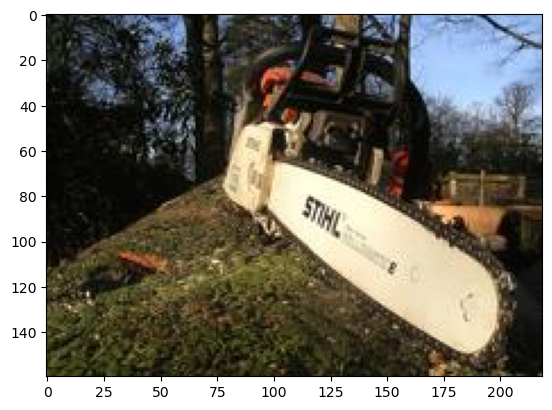

In [48]:
%matplotlib inline
im = Image.open(test[344], 'r')
plt.imshow(np.asarray(im))


In [49]:
transform = ImageAugmentationDINO(global_crops_scale, local_crops_scale, local_crops_number)

train_dataset = datasets.ImageFolder(root=path/'train', transform=transform)

In [50]:
print(train_dataset)
print(len(test))

Dataset ImageFolder
    Number of datapoints: 9469
    Root location: /home/conradb/.fastai/data/imagenette2-160/train
    StandardTransform
Transform: <dino.augment.ImageAugmentationDINO object at 0x7fa6c1d45280>
9469


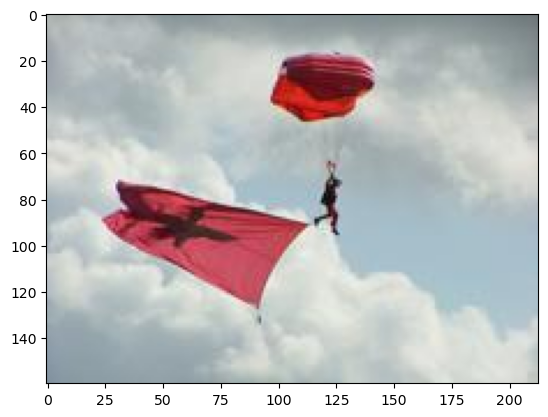

In [51]:
%matplotlib inline
im = Image.open(train_dataset.imgs[9060][0], 'r')
plt.imshow(np.asarray(im))

In [52]:
data_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, drop_last=True)

In [53]:
one_sample = next(iter(data_loader))
print(len(one_sample[0]))
print(len(one_sample[1]))
print(one_sample[0][9].shape)

10
128
torch.Size([128, 3, 96, 96])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


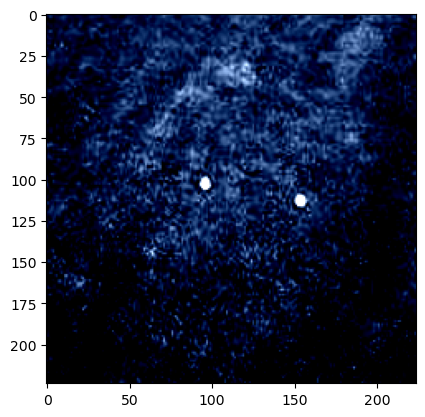

In [54]:
plt.imshow(one_sample[0][1][3].permute(1,2,0).numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


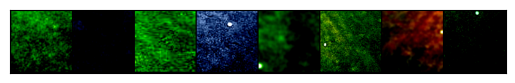

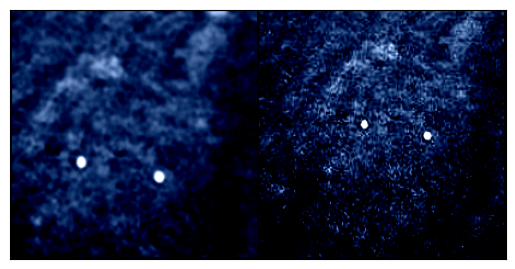

In [55]:
plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.permute(1,2,0)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


list_local = [*one_sample[0][2:10]] # grab local crops
list_global = [*one_sample[0][0:2]] # grab global crops
grid_local = make_grid([a[3] for a in list_local], nrow=8) # where n in a[n] is a batch sample
grid_global = make_grid([a[3] for a in list_global], nrow=2) # where n in a[n] is a batch sample
show(grid_local)
show(grid_global)

In [56]:
student = vit.__dict__[model](patch_size=16, drop_path_rate=0.1)
teacher = vit.__dict__[model](patch_size=16)
embed_dim = student.embed_dim

In [57]:
# multi-crop wrapper handles forward with inputs of different resolutions
student = utils.MultiCropWrapper(student, DINOHead(embed_dim, out_dim, use_bn=use_bn_head, norm_last_layer=norm_last_layer))
teacher = utils.MultiCropWrapper(teacher, DINOHead(embed_dim, out_dim, use_bn=use_bn_head))

In [58]:
if device == 'gpu':
    student, teacher = student.cuda(), teacher.cuda()
else:
    student, teacher = student.cpu(), teacher.cpu()

In [59]:
teacher.load_state_dict(student.state_dict())

<All keys matched successfully>

In [60]:
# there is no backpropagation through the teacher, so no need for gradients
for p in teacher.parameters():
    p.requires_grad = False

In [61]:
dino_loss = DINOLoss(
        out_dim,
        local_crops_number + 2,  # total number of crops = 2 global crops + local_crops_number
        warmup_teacher_temp,
        teacher_temp,
        warmup_teacher_temp_epochs,
        epochs,
        )

if device == 'gpu':
    dino_loss = dino_loss.cuda()
else:
    dino_loss = dino_loss.cpu()

In [62]:
params_groups = utils.get_params_groups(student)
optimizer = torch.optim.AdamW(params_groups)  # to use with ViTs

In [63]:
lr_schedule = utils.cosine_scheduler(
        lr * (batch_size * utils.get_world_size()) / 256.,  # linear scaling rule
        min_lr, epochs, len(data_loader), warmup_epochs=warmup_epochs)

wd_schedule = utils.cosine_scheduler(weight_decay, weight_decay_end, epochs, len(data_loader))

# momentum parameter is increased to 1. during training with a cosine schedule
momentum_schedule = utils.cosine_scheduler(momentum_teacher, 1, epochs, len(data_loader))

TO DO - Add checkpoint restart option 

In [64]:
for epoch in range(0, epochs):

    running_loss = 0
    counts = 0

    for it, (images, _) in enumerate(data_loader):

        it = len(data_loader) * epoch + it  # global training iteration

        for i, param_group in enumerate(optimizer.param_groups):
            param_group["lr"] = lr_schedule[it]
            if i == 0:  # only the first group is regularized
                param_group["weight_decay"] = wd_schedule[it]

        # teacher and student forward passes + compute dino loss
        teacher_output = teacher(images[:2])  # only the 2 global views pass through the teacher
        student_output = student(images)
        loss = dino_loss(student_output, teacher_output, epoch)

        running_loss += loss
        counts += 1

        if not math.isfinite(loss.item()):
            print("Loss is {}, stopping training".format(loss.item()), force=True)
            sys.exit(1)

        # student update
        optimizer.zero_grad()
        param_norms = None
        loss.backward()

        param_norms = utils.clip_gradients(student, 3.0)
        utils.cancel_gradients_last_layer(epoch, student, 1)
        optimizer.step()

        # EMA update for the teacher
        with torch.no_grad():
            m = momentum_schedule[it]  # momentum parameter
            for param_q, param_k in zip(student.parameters(), teacher.parameters()):
                param_k.data.mul_(m).add_((1 - m) * param_q.detach().data)

    epoch_loss = running_loss / counts
    print(f'Epoch {epoch} loss is {epoch_loss}')

    if epoch % 5 == 0:

        save_dict = {
            'student': student.state_dict(),
            'teacher': teacher.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch': epoch + 1,
            'dino_loss': dino_loss.state_dict(),
            }
        
        torch.save(save_dict, 'dino/dino_checkpoints/dino_imagenette_160_ckpt_cpu.pth')

tensor(8.9879, grad_fn=<DivBackward0>)
tensor(8.9849, grad_fn=<DivBackward0>)
tensor(8.9360, grad_fn=<DivBackward0>)
tensor(8.9625, grad_fn=<DivBackward0>)
tensor(8.9626, grad_fn=<DivBackward0>)
tensor(8.9165, grad_fn=<DivBackward0>)
tensor(8.8626, grad_fn=<DivBackward0>)
tensor(8.8717, grad_fn=<DivBackward0>)
tensor(8.8226, grad_fn=<DivBackward0>)
tensor(8.5409, grad_fn=<DivBackward0>)
tensor(8.4498, grad_fn=<DivBackward0>)
tensor(8.1664, grad_fn=<DivBackward0>)
tensor(7.8241, grad_fn=<DivBackward0>)
tensor(7.0844, grad_fn=<DivBackward0>)
tensor(6.9049, grad_fn=<DivBackward0>)


KeyboardInterrupt: 